# Intro

In this tutorial, we apply ARGEN to the entire chromosomes and reproduce relevant results in the manuscript.

# Arguments and set up

To run the codes, **(i)** designate the directory, where ARGEN was cloned from the Github repository, **(ii)** number of CPU cores to be used for parallel jobs, **(iii)** the significance level $\alpha$ for descendant set search and the parent set search.

In [ ]:
DIR='/kmp0223/ARGEN/'
ncores=30
alpha_desc=alpha_IV = 0.05

Set up options and directories to run the codes.

# Load functions

In [2]:
source(paste0(DIR,'/code/function/application/Proxy_IV_functions_parallel.R'))

# Run codes across chromosomes

In [15]:
options(future.globals.maxSize = 10 * 1024^3) 
set.seed(1)
chrlist=paste0('chr',c(1:22,"X"))

for(chr in 1:23){
DAG_DIR <- paste0(DIR,'/results/application/',chrlist[chr])
if (!dir.exists(DAG_DIR)) dir.create(DAG_DIR, recursive = TRUE, showWarnings = FALSE)    
    

# Load and prepare for the data
## Load data from the data directory. **X_raw** contains the UMI count across cells and genes and **meta_data** contains cell specific feature information.    
X_raw  <- qs::qread(paste0(DIR,'/data/',chrlist[chr],"/X_raw_",chrlist[chr],'.qs'))
meta_data <- qs::qread(paste0(DIR,'/data/',chrlist[chr],"/meta_data_",chrlist[chr],'.qs'))

nodes <- colnames(X_raw) # Node (gene) set.
p <- length(nodes) # dimension of X_raw.
perturbation_unique <- unique(meta_data$gene_id) # Perturbation set: Gene set+non targeting guides.
meta_data$gene_id <- factor(meta_data$gene_id,levels = unique(meta_data$gene_id)) 
meta_data$gem_group<-factor(meta_data$gem_group) # making sure GEM group is a factor.

C <- meta_data$guide_UMI_sum / mean(meta_data$guide_UMI_sum) # Library size estimation.    
    
## Prepare for the binary perturbation indicator matrix **D**, which is of the same dimension as **X_raw** matrix.    
D <- model.matrix(~ gene_id - 1, data = meta_data)
colnames(D) <- sub("^gene_id", "", colnames(D))
D <- D[, -c(length(perturbation_unique))]
control_ind <- which(rowSums(D) == 0)    
    

# Descendant set search

cat(paste0('Running codes for ',chrlist[chr],'\n'))
cat(paste0('Estimating Ancestors and Descendants...','\n'))
  
ds_out <- build_descendants_cov_adjust(
    X_raw = X_raw,
    D = D, 
    control_ind = control_ind,
    alpha_desc = alpha_desc, nodes = nodes,
    padj_method = "BH",
    cc_cols=c('mitopercent', "gem_group"),
    cc_df=meta_data %>% as.data.frame,depth=C,
    ncores = ncores, engine = "multisession"
  )

# saving the descendant sets estimated.
setwd(DAG_DIR)
qs::qsave(ds_out,'ds_out_covadjust.qs')
    
# Parent set and causal DAG search    
cat(paste0('Estimating Parents...','\n'))
dag_obj <- dag_search_perturbseq(
    desc_sets = ds_out$descendant_set_score_closure,
    data_raw  = X_raw ,
    D = D ,depth =C,family = 'poisson',cc_df=data.frame(meta_data),
    cc_cols = c('mitopercent', "gem_group"),alpha_parent=alpha_IV,
    padj_method_parent='onlineBH',
    cores = ncores
  )

cat(paste0(chrlist[chr],' complete!','\n'))    

    
# Saving the DAG learned from ARGEN
    
edges_k <- edges_from_dagsearch(dag_obj)
maps_k  <- compute_ancestors_map(nodes, edges_k)
dag_artifact <- list(
    dag_object    = dag_obj,
    dag_edges     = edges_k,
    parents_map   = maps_k$parents_map,
    ancestors_map = maps_k$ancestors_map
)
  
  
saveRDS(dag_artifact, file = file.path(DAG_DIR,  'dag_0.05BH_0.05onlineBH.rds'))
    
    
    
}




# Reproducing main results

## Coefficient sign match across chromosomes

First, we load the DAG estimate learned from **ARGEN** and rename the genes using their corresponding standard gene symbols based on ENSG identifiers.

In [3]:
library(dplyr)
library(data.table)
meta_data_allchr <- fread(paste0(DIR,'/data/meta_data_allchr.csv'))
id2name <- meta_data_allchr %>%
  distinct(gene_id, gene) %>%
  mutate(across(everything(), as.character))


chrlist=paste0('chr',c(1:22,"X"))
true_edges=c()
all_edges=c()
for(chr in c(1:23)){
chrlist=paste0('chr',c(1:22,"X"))
DAG_DIR <- paste0(DIR,'/results/application/',chrlist[chr])
setwd(DAG_DIR)
dag_artifact=readRDS(file = 'dag_0.05BH_0.05onlineBH.rds')
true_edges=rbind(true_edges,data.frame(chr=chrlist[chr],dag_artifact$dag_edges))
all_edges=rbind(all_edges,data.frame(chr=chrlist[chr],do.call('rbind',dag_artifact$dag_object$edge_structure_all)))
    }


true_edges_name=  true_edges %>%
    mutate(from = as.character(from), to = as.character(to)) %>%
    left_join(id2name, by = c("from" = "gene_id")) %>%
    rename(from_gene = gene) %>%
    left_join(id2name, by = c("to" = "gene_id")) %>%
    rename(to_gene = gene)


all_edges_name=all_edges %>%
    mutate(from = as.character(from), to = as.character(to)) %>%
    left_join(id2name, by = c("from" = "gene_id")) %>%
    rename(from_gene = gene) %>%
    left_join(id2name, by = c("to" = "gene_id")) %>%
    rename(to_gene = gene)


Next, obtain the intervention effects of perturbing parent genes on their child genes. Then, compare the signs of these intervention effects with those of the corresponding edge coefficients.

In [9]:
plan(multicore, workers = 30)# adjust the core number based on availability.


suppressPackageStartupMessages({
  library(future.apply)   
  library(data.table)     
  library(sandwich)
  library(lmtest)
})


blas_threads=1
if (blas_threads == 1) {
    Sys.setenv(
      OMP_NUM_THREADS = "1", OPENBLAS_NUM_THREADS = "1",
      MKL_NUM_THREADS = "1", VECLIB_MAXIMUM_THREADS = "1",
      BLIS_NUM_THREADS = "1", GOTO_NUM_THREADS = "1"
    )
    if (requireNamespace("RhpcBLASctl", quietly = TRUE)) {
      RhpcBLASctl::blas_set_num_threads(1)
      RhpcBLASctl::omp_set_num_threads(1)
    }
    if (requireNamespace("data.table", quietly = TRUE)) {
      data.table::setDTthreads(1)
    }
  }
    
    


   
chrlist <- paste0('chr', c(1:22, "X"))


process_chr <- function(chr) {


  
    X_raw  <- qs::qread(paste0(DIR,'/data/',chrlist[chr],"/X_raw_",chrlist[chr],'.qs'))
    meta_data <- qs::qread(paste0(DIR,'/data/',chrlist[chr],"/meta_data_",chrlist[chr],'.qs'))
  # Design for perturbations
  perturbation_unique <- unique(meta_data$gene_id)
  meta_data$gene_id <- factor(meta_data$gene_id,
                                            levels = unique(meta_data$gene_id))
  meta_data$gem_group <- as.factor(meta_data$gem_group)

  D <- model.matrix(~ gene_id - 1, data = meta_data)
  colnames(D) <- sub("^gene_id", "", colnames(D))
  D <- D[, -c(length(perturbation_unique))] 
  control_ind <- which(rowSums(D) == 0)

  # Offset vector (depth)
  C <- meta_data$guide_UMI_sum / mean(meta_data$guide_UMI_sum)

  # Covariates (use model.matrix to expand factors robustly)
  cc_cols <- c('mitopercent', "gem_group")
  cc_df <- as.data.frame(meta_data %>% dplyr::select(cc_cols))
  # build a model matrix with intercept; will create gem_group dummies
  X_cc_all <- model.matrix(~ ., data = cc_df)

  chrom <- chrlist[chr]
  df <- true_edges_name %>% dplyr::filter(chr == chrom)

  if (nrow(df) == 0L) {
    return(data.table(beta = NA_real_, pval = NA_real_, chr = chrom)[0])
  }

  # --------- parallel over i (rows of df) ----------
  res_list_i <- future_lapply(
    seq_len(nrow(df)),
    function(i) {
      fg <- df$from_gene[i]
      tg <- df$to_gene[i]


      fg_id <- unique(meta_data$gene_id[meta_data$gene == fg])
      tg_id <- unique(meta_data$gene_id[meta_data$gene == tg])

      if (length(fg_id) != 1L || length(tg_id) != 1L) {
        return(data.frame(beta = NA_real_, pval = NA_real_, from = fg, to = tg))
      }

      perturb_ind <- D[, fg_id] == 1
      if (!any(perturb_ind) || length(control_ind) == 0L) {
        return(data.frame(beta = NA_real_, pval = NA_real_, from = fg, to = tg))
      }

      # response and treatment
      x1 <- X_raw[perturb_ind, tg_id]
      x0 <- X_raw[control_ind, tg_id]
      y  <- c(x1, x0)
      d  <- c(D[perturb_ind, fg_id], D[control_ind, fg_id])

      # covariate rows aligned to perturb/control
      Xc <- rbind(X_cc_all[perturb_ind, , drop = FALSE],
                  X_cc_all[control_ind, , drop = FALSE])

      depth <- c(C[perturb_ind], C[control_ind])

      # build data and fit
      tmpdat <- data.frame(y = y, d = d, Xc, check.names = TRUE)
      fml <- stats::as.formula(
        paste0("y ~ d + ",
               paste(setdiff(colnames(Xc), "(Intercept)"), collapse = " + "))
      )

      glmres <- glm(fml, offset = log(pmax(depth, 1e-12)),
                    data = tmpdat, family = poisson())

      beta <- coef(glmres)['d']

      data.frame(beta = beta, from = fg, to = tg, stringsAsFactors = FALSE)
    },
    future.seed = TRUE
  )

  res_chr <- data.table::rbindlist(res_list_i, use.names = TRUE, fill = TRUE)
  res_chr[, chr := chrom]
  res_chr
}


res_list_chr <- lapply(1:23, process_chr)
res_allchr   <- data.table::rbindlist(res_list_chr, use.names = TRUE, fill = TRUE)

df_allchr=true_edges_name%>% mutate(intervention_coef=res_allchr$beta)
qs::qsave(df_allchr,paste0(DIR,'/results/application/sanity_check_coef.qs'))

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(cc_cols)

  # Now:
  data %>% select(all_of(cc_cols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


Visualize the comparison between the edge coefficients and the intervention effects. The figure below reproduces Fig 3d of the manuscript.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 5 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 5 rows containing missing values or values outside the scale range (`geom_point()`).”


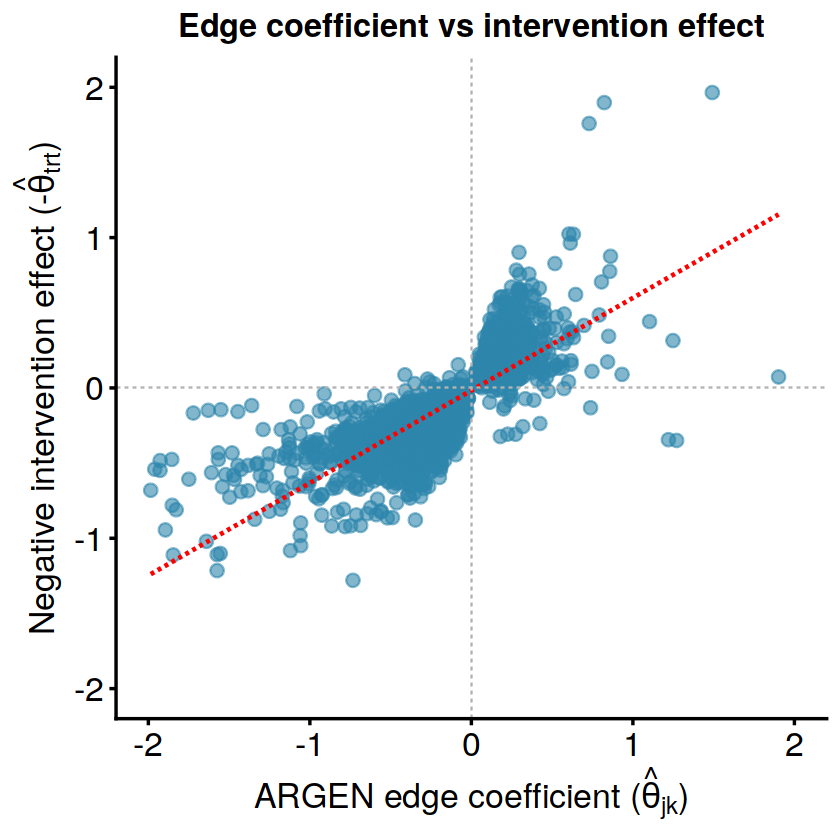

In [4]:
library(ggplot2)

ggplot(df_allchr , aes(x = coef, y = -intervention_coef)) +
  geom_point(alpha = 0.6, size = 3, color = "#2E86AB")+geom_smooth(method="lm",lwd=1,lty=2,col='red',se=FALSE) +
  labs(
    y = expression("Negative intervention effect (-" * hat(theta)[trt] * ")"),
    x =  expression("ARGEN edge coefficient (" * hat(theta)[jk] * ")"),
    title = "Edge coefficient vs intervention effect"
  ) +
  theme_classic(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 20)
  )+
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray70", linewidth = 0.5) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray70", linewidth = 0.5) +ylim(-2,2)+xlim(-2,2)

## Coefficient sign match across chromosomes (reversed order)

Now, obtain the (reversed) intervention effects of perturbing children genes on their parent genes. Then, compare the signs of these intervention effects with those of the corresponding edge coefficients.

In [13]:
# Per-chromosome worker: parallelize the inner i-loop
process_chr <- function(chr) {

    X_raw  <- qs::qread(paste0(DIR,'/data/',chrlist[chr],"/X_raw_",chrlist[chr],'.qs'))
    meta_data <- qs::qread(paste0(DIR,'/data/',chrlist[chr],"/meta_data_",chrlist[chr],'.qs'))
  
  # Design for perturbations
  perturbation_unique <- unique(meta_data$gene_id)
  meta_data$gene_id <- factor(meta_data$gene_id,
                                            levels = unique(meta_data$gene_id))
  meta_data$gem_group <- as.factor(meta_data$gem_group)
  
  D <- model.matrix(~ gene_id - 1, data = meta_data)
  colnames(D) <- sub("^gene_id", "", colnames(D))
  D <- D[, -c(length(perturbation_unique))] 
  control_ind <- which(rowSums(D) == 0)
  
  # Offset vector (depth)
  C <- meta_data$guide_UMI_sum / mean(meta_data$guide_UMI_sum)
  

  cc_cols <- c('mitopercent', "gem_group")
  cc_df <- as.data.frame(meta_data %>% dplyr::select(cc_cols))
  # build a model matrix with intercept; will create gem_group dummies
  X_cc_all <- model.matrix(~ ., data = cc_df)
  
  chrom <- chrlist[chr]
  df <- true_edges_name %>% dplyr::filter(chr == chrom)
  
  if (nrow(df) == 0L) {
    return(data.table(beta = NA_real_, pval = NA_real_, chr = chrom)[0])  # empty
  }
  
  # --------- parallel over i (rows of df) ----------
  res_list_i <- future_lapply(
    seq_len(nrow(df)),
    function(i) {
      fg <- df[i, ]$to_gene
      tg <- df[i, ]$from_gene
      

      fg_id <- unique(meta_data$gene_id[meta_data$gene == fg])
      tg_id <- unique(meta_data$gene_id[meta_data$gene == tg])
      
      if (length(fg_id) != 1L || length(tg_id) != 1L) {
        return(data.frame(beta = NA_real_, pval = NA_real_, from = fg, to = tg))
      }
      
      perturb_ind <- D[, fg_id] == 1
      if (!any(perturb_ind) || length(control_ind) == 0L) {
        return(data.frame(beta = NA_real_, pval = NA_real_, from = fg, to = tg))
      }
      
      # response and treatment
      x1 <- X_raw[perturb_ind, tg_id]
      x0 <- X_raw[control_ind, tg_id]
      y  <- c(x1, x0)
      d  <- c(D[perturb_ind, fg_id], D[control_ind, fg_id])
      
      # covariate rows aligned to perturb/control
      Xc <- rbind(X_cc_all[perturb_ind, , drop = FALSE],
                  X_cc_all[control_ind, , drop = FALSE])
      
      depth <- c(C[perturb_ind], C[control_ind])
      
      # build data and fit
      tmpdat <- data.frame(y = y, d = d, Xc, check.names = TRUE)
      fml <- stats::as.formula(
        paste0("y ~ d + ",
               paste(setdiff(colnames(Xc), "(Intercept)"), collapse = " + "))
      )
      
      glmres <- glm(fml, offset = log(pmax(depth, 1e-12)),
                    data = tmpdat, family = poisson())
      
      test  <- lmtest::coeftest(glmres, vcov = sandwich::vcovHC(glmres, type = "HC0"))

      if ("d" %in% rownames(test)) {
        beta <- unname(test["d", 1])
        pval <- unname(test["d", 4])
      } else {

        beta <- unname(test[2, 1])
        pval <- unname(test[2, 4])
      }
      
      data.frame(beta = beta, pval = pval, from = fg, to = tg, stringsAsFactors = FALSE)
    },
    future.seed = TRUE
  )
  
  res_chr <- data.table::rbindlist(res_list_i, use.names = TRUE, fill = TRUE)
  res_chr[, chr := chrom]
  res_chr
}


res_list_chr <- lapply(1:23, process_chr)  # <- sequential here
res_allchr   <- data.table::rbindlist(res_list_chr, use.names = TRUE, fill = TRUE)

df_allchr_reversed=true_edges_name%>% mutate(intervention_coef=res_allchr$beta,intervention_p=res_allchr$pval)
qs::qsave(df_allchr_reversed,paste0(DIR,'/results/application/sanity_check_coef_reversed.qs'))

Visualize the comparison between the edge coefficients and the intervention effects. The figure below reproduces Fig 3e of the manuscript.

`geom_smooth()` using formula = 'y ~ x'
Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_smooth()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range (`geom_point()`).”


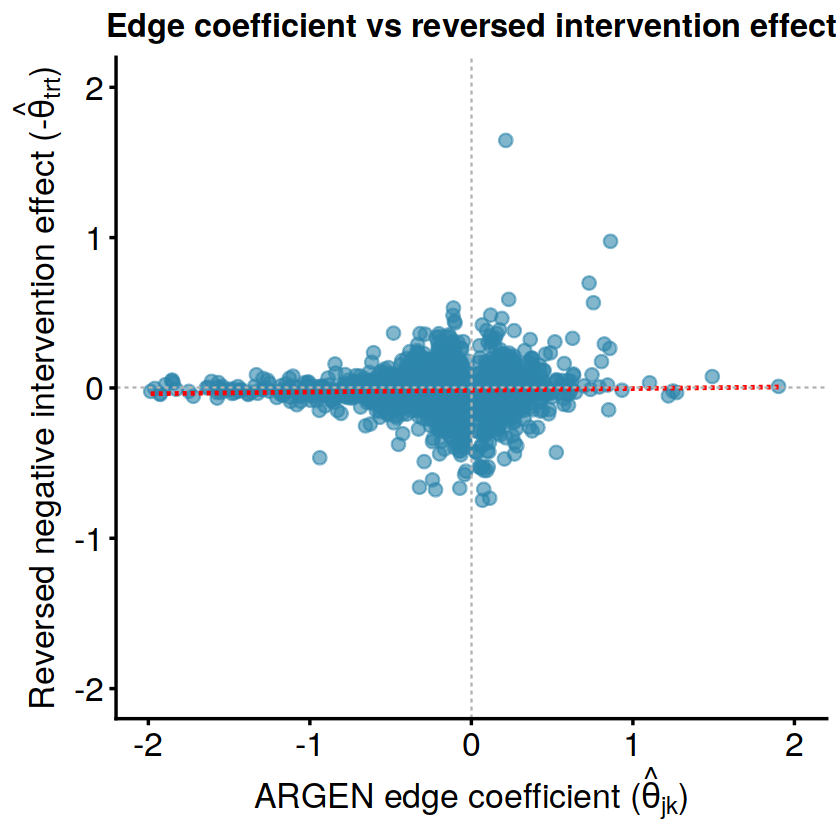

In [6]:
ggplot(df_allchr_reversed, aes(x = coef, y = -intervention_coef)) +
  geom_point(alpha = 0.6, size = 3, color = "#2E86AB") +
geom_smooth(method="lm",lwd=1,lty=2,col='red',se=FALSE)+
  labs(
    y = expression("Reversed negative intervention effect (-" * hat(theta)[trt] * ")"),
    x =  expression("ARGEN edge coefficient (" * hat(theta)[jk] * ")"),
    title = "Edge coefficient vs reversed intervention effect"
  ) +
  theme_classic(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    axis.title = element_text(size = 20),
    axis.text = element_text(size = 20)
  )+
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray70", linewidth = 0.5) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray70", linewidth = 0.5) +ylim(-2,2)+xlim(-2,2)

# Investigation of edge strengths in A/B compartments

Next, we show how the edge strengths differ across A and B compartments of the K562 cells. First, read in the gtf file containing the gemomic locations of the genes.

In [10]:
suppressPackageStartupMessages({
  library(GenomicFeatures)
  library(Matrix)    
})

# ==== 2) Load GTF and extract gene-level info ====
gtf_file <- paste0(DIR,'/data/gencode.v19.annotation.gtf.gz')
txdb <- makeTxDbFromGFF(gtf_file, format="gtf")
# Extract all gene ranges
gr <- genes(txdb)  # GRanges with gene_id as names

# Build a plain data.frame
gene_tbl <- data.frame(
  gene_id = names(gr),
  chr     = as.character(seqnames(gr)),
  start   = start(gr),
  end     = end(gr),
  strand  = as.character(strand(gr)),
  stringsAsFactors = FALSE
) %>%
  filter(chr %in% paste0("chr", c(1:22, "X", "Y"))) %>%  # optional filtering
  mutate(
    tss = ifelse(strand == "+", start, end)
  )

# confirm


gene_tbl <- gene_tbl %>%
  mutate(chr  = as.character(chr),
         tss  = as.numeric(tss),
         gene_id_clean = sub("\\.\\d+$", "", gene_id))

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK



Read in the compartment information as below.

In [14]:
compartment_dt <- readRDS(paste0(DIR,'/data/compartment_dt.rds'))

Load the learned DAG results across all the chromosomes.

In [24]:
chrlist <- paste0('chr', c(1:22, "X"))
edges_all_chr <- c()
called_edges_df <- c()

for(chr in c(1:23)){

  DAG_DIR <- paste0(DIR,'/results/application/',chrlist[chr])
setwd(DAG_DIR)
dag_artifact=readRDS(file = 'dag_0.05BH_0.05onlineBH.rds')

  edges <- do.call('rbind', dag_artifact$dag_object$edge_structure_all)

  edges <- edges %>%
    mutate(from = sub("\\.\\d+$", "", from),
           to   = sub("\\.\\d+$", "", to))

  edges_annot <- edges %>%
    left_join(gene_tbl %>% dplyr::select(gene_id_clean, chr, tss, strand),
              by = c("from" = "gene_id_clean")) %>%
    dplyr::rename(chr_from = chr, tss_from = tss, strand_from = strand) %>%
    left_join(gene_tbl %>% dplyr::select(gene_id_clean, chr, tss, strand),
              by = c("to" = "gene_id_clean"),
              suffix = c("", "_to")) %>%
    dplyr::rename(chr_to = chr, tss_to = tss, strand_to = strand)

  edges_same_chr <- edges_annot %>% filter(chr_from == chr_to)
  edges_all_chr <- rbind(edges_all_chr, edges_same_chr)

  called_tmp <- do.call('rbind', dag_artifact$dag_object$edge_structure) %>%
    mutate(from = sub("\\.\\d+$", "", from),
           to   = sub("\\.\\d+$", "", to)) %>%
    dplyr::select(from, to)

  called_edges_df <- rbind(called_edges_df, called_tmp)
}

edges_all_chr <- as.data.table(edges_all_chr)
called_edges_df <- unique(as.data.table(called_edges_df), by = c("from","to"))

edges_all_chr[, is_called := FALSE]
edges_all_chr[called_edges_df, on = .(from, to), is_called := TRUE]


For each edge in the DAGs, assign compartment labels by determining which compartment each node belongs to.

In [25]:
library(data.table)

edges <- as.data.table(copy(edges_all_chr))
comp  <- as.data.table(copy(compartment_dt))

bin_size <- 1000000
up_bp    <- 1000
down_bp  <- 0

# -----------------------------
# 1) Build promoter intervals (BED-like, 0-based half-open)
#    For + strand: [TSS-10kb, TSS)
#    For - strand: [TSS, TSS+10kb)
# -----------------------------
edges[, `:=`(
  prom_from_start = ifelse(strand_from == "+", tss_from - up_bp, tss_from + down_bp),
  prom_from_end   = ifelse(strand_from == "+", tss_from + down_bp, tss_from + up_bp),

  prom_to_start   = ifelse(strand_to   == "+", tss_to   - up_bp, tss_to   + down_bp),
  prom_to_end     = ifelse(strand_to   == "+", tss_to   + down_bp, tss_to   + up_bp)
)]

# guard against negative coordinates (can happen near chr start)
edges[prom_from_start < 0, prom_from_start := 0L]
edges[prom_to_start   < 0, prom_to_start   := 0L]

# -----------------------------
# 2) Map promoter midpoint to compartment bin start
# -----------------------------
edges[, prom_from_mid := as.integer(floor((prom_from_start + prom_from_end) / 2))]
edges[, prom_to_mid   := as.integer(floor((prom_to_start   + prom_to_end)   / 2))]

edges[, bin_from := as.integer(floor(prom_from_mid / bin_size) * bin_size)]
edges[, bin_to   := as.integer(floor(prom_to_mid   / bin_size) * bin_size)]

# -----------------------------
# 3) Join compartment labels
# -----------------------------
comp_from <- unique(comp[, .(chr = chr, bin = bin, comp_from = compartment)])
comp_to   <- unique(comp[, .(chr = chr, bin = bin, comp_to   = compartment)])

setkey(comp_from, chr, bin)
setkey(comp_to,   chr, bin)

edges <- comp_from[edges, on = .(chr = chr_from, bin = bin_from)]
edges <- comp_to[edges,   on = .(chr = chr_to,   bin = bin_to)]

# -----------------------------
# 4) Build edge labels: AA/AB/BA/BB and collapsed A/B/crossAB
# -----------------------------
edges[, edge_comp_dir := fifelse(is.na(comp_from) | is.na(comp_to), NA_character_,
                                 paste0(comp_from, comp_to))]

edges[, edge_comp2 := fifelse(is.na(comp_from) | is.na(comp_to), NA_character_,
                              fifelse(comp_from == comp_to, comp_from, "crossAB"))]

edges_all_chr <- edges


For edges called significant by ARGEN, we examine the $-\log{\mbox{(p-value)}}$ of edges across the A and B compartments. The figure below reproduces Fig 4b of the manuscript.

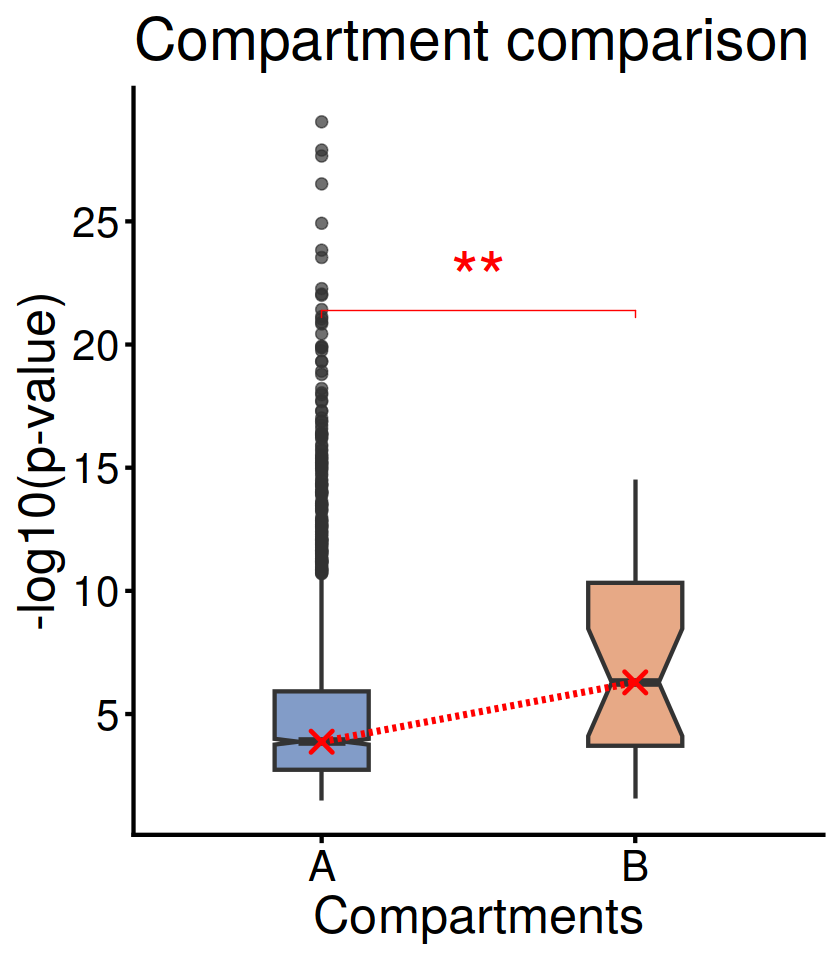

In [26]:
library(ggpubr)
edges_all_chr[, nlog10p := -log10(p_raw)]
options(repr.plot.width=7, repr.plot.height=8)
# keep only AA vs BB (drop crossAB and NAs)
plot_df <- edges_all_chr[
  edge_comp2 %in% c("A","B") &
    is.finite(nlog10p)
]

p=ggplot(plot_df %>% filter(is_called), aes(x = edge_comp2, y = nlog10p, fill = edge_comp2)) +
  geom_boxplot(notch = TRUE, width = 0.3, alpha = 0.7) +
  
  # median X marks
  stat_summary(
    fun = median,
    geom = "point",
    size = 5,
    color = "red",
    shape = 4, stroke = 1.5
  ) +
  
  # connect medians
  stat_summary(
    fun = median,
    geom = "line",
    aes(group = 1),
    linewidth = 1.5,
    lty = 2,
    color = "red"
  ) +
  stat_compare_means(
    comparisons = list(c("A", "B")),
    method = "wilcox.test",
    alternative = "greater",
    label = "p.signif",
    size = 15,
    color = "red",    label.y =20,
    tip.length = 0.01 
  )+
  
  scale_fill_manual(
    values = c(
      "A" = "#4C72B0",  
      "B" = "#DD8452"  
    )
  ) +ggtitle("Compartment comparison")+
  
  labs(x = "Compartments", y = "-log10(p-value)") +
  theme_classic(base_size = 20) +
  theme(legend.position = "none",plot.title=element_text(size=35))+ scale_y_continuous(breaks = seq(0, max(plot_df$nlog10p, na.rm = TRUE), by = 5))+
  theme(
    axis.text = element_text(size = 25),
    axis.title = element_text(size = 30)
  )


p
